# Descriptor Performance Overview

This notebook provides a comprehensive analysis of SIFT descriptor performance with different pooling strategies using the HPatches benchmark dataset.

## 📊 **Analysis Overview:**

### **Experiment Setup:**
- **Base Descriptor**: SIFT (grayscale)
- **Pooling Strategies**: None (baseline), DSP (Domain-Size Pooling), Stacking
- **Dataset**: HPatches (illumination + viewpoint changes)
- **Evaluation**: Macro MAP, Micro MAP, Precision@K metrics
- **Total Experiments**: 4 configurations tested

### **Key Research Questions:**
1. **Performance Impact**: How much do pooling strategies improve descriptor matching?
2. **Efficiency Trade-offs**: What's the computational cost vs. performance gain?
3. **Metric Consistency**: Do Macro and Micro MAP tell the same story?
4. **Practical Implications**: Which approach offers the best balance for real applications?

### **Expected Findings:**
- DSP pooling should show performance improvements over baseline
- Processing time will increase with more complex pooling strategies
- Different scenes (illumination vs viewpoint) may respond differently to pooling

In [9]:
# Import required libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Database connection
DB_PATH = "../../build/experiments.db"

In [10]:
# Connect to database and load experiment data
def load_experiment_data():
    conn = sqlite3.connect(DB_PATH)
    
    query = """
    SELECT 
        e.id as experiment_id,
        e.descriptor_type,
        e.pooling_strategy,
        e.dataset_name,
        e.similarity_threshold,
        e.max_features,
        r.mean_average_precision,
        r.true_map_macro,
        r.true_map_micro,
        r.true_map_macro_with_zeros,
        r.true_map_micro_with_zeros,
        r.legacy_mean_precision,
        r.precision_at_1,
        r.precision_at_5,
        r.recall_at_1,
        r.recall_at_5,
        r.total_matches,
        r.total_keypoints,
        r.processing_time_ms,
        r.metadata
    FROM experiments e 
    JOIN results r ON e.id = r.experiment_id
    ORDER BY e.id DESC
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    return df

# UPDATED: No longer need to extract from metadata - using primary columns
def process_map_columns(df):
    """Process MAP columns and provide backward compatibility aliases"""
    df = df.copy()
    
    # Create aliases for compatibility with existing code
    df['macro_map'] = df['true_map_macro']
    df['micro_map'] = df['true_map_micro']
    df['macro_map_with_zeros'] = df['true_map_macro_with_zeros']
    df['micro_map_with_zeros'] = df['true_map_micro_with_zeros']
    
    # Handle NaN values that might exist in older records
    df['macro_map'] = df['macro_map'].fillna(df['mean_average_precision'])
    df['micro_map'] = df['micro_map'].fillna(df['mean_average_precision'])
    
    return df

# Load data
df = load_experiment_data()
df = process_map_columns(df)
print(f"Loaded {len(df)} experiment results")
print("Available MAP metrics (using primary columns):")
print(f"- Primary MAP: {df['mean_average_precision'].min():.4f} - {df['mean_average_precision'].max():.4f}")
print(f"- Macro MAP: {df['macro_map'].min():.4f} - {df['macro_map'].max():.4f}")
print(f"- Micro MAP: {df['micro_map'].min():.4f} - {df['micro_map'].max():.4f}")
if df['legacy_mean_precision'].notna().any():
    print(f"- Legacy MAP: {df['legacy_mean_precision'].min():.4f} - {df['legacy_mean_precision'].max():.4f}")
df.head()

Loaded 40 experiment results
Available MAP metrics (using primary columns):
- Primary MAP: 0.3703 - 0.5501
- Macro MAP: 0.3703 - 0.5501
- Micro MAP: 0.3724 - 0.5450
- Legacy MAP: 0.3826 - 0.5338


,experiment_id,descriptor_type,pooling_strategy,dataset_name,similarity_threshold,max_features,mean_average_precision,true_map_macro,true_map_micro,true_map_macro_with_zeros,true_map_micro_with_zeros,legacy_mean_precision,precision_at_1,precision_at_5,recall_at_1,recall_at_5,total_matches,total_keypoints,processing_time_ms,metadata,macro_map,micro_map,macro_map_with_zeros,micro_map_with_zeros
0,40,dspsift_color_stacking_l2,stacking,../data/,0.8,2000,0.525271,0.525271,0.521879,0.484795,0.472547,0.530925,0.479841,0.564206,0.479841,0.564206,64501,101940,64813.0,compute_time_ms=26107.000000;detect_time_ms=0....,0.525271,0.521879,0.484795,0.472547
1,39,dspsift_grayscale_stacking_l2,stacking,../data/,0.8,2000,0.525271,0.525271,0.521879,0.484795,0.472547,0.530925,0.479841,0.564206,0.479841,0.564206,64501,101940,65033.0,compute_time_ms=26193.000000;detect_time_ms=0....,0.525271,0.521879,0.484795,0.472547
2,38,dspsift_color_dsp_l1,domain_size_pooling,../data/,0.8,2000,0.550113,0.550113,0.544967,0.506100,0.493452,0.533765,0.503414,0.587436,0.503414,0.587436,67693,101940,130871.0,compute_time_ms=97831.000000;detect_time_ms=0....,0.550113,0.544967,0.506100,0.493452
3,37,dspsift_baseline_grayscale_dsp_l1,domain_size_pooling,../data/,0.8,2000,0.550104,0.550104,0.544956,0.506090,0.493442,0.533552,0.503404,0.587367,0.503404,0.587367,67697,101940,129211.0,compute_time_ms=95983.000000;detect_time_ms=0....,0.550104,0.544956,0.506090,0.493442
4,36,dspsift_baseline_color_dsp_l2,domain_size_pooling,../data/,0.8,2000,0.550113,0.550113,0.544967,0.506100,0.493452,0.533765,0.503414,0.587436,0.503414,0.587436,67693,101940,129615.0,compute_time_ms=96668.000000;detect_time_ms=0....,0.550113,0.544967,0.506100,0.493452


In [25]:
# Data preprocessing and feature extraction
def extract_descriptor_features(df):
    """Extract features from descriptor names for analysis"""
    df = df.copy()
    
    # Extract color information
    df['uses_color'] = df['descriptor_type'].str.contains('rgb', case=False)
    
    # Extract base descriptor type
    df['base_descriptor'] = df['descriptor_type'].str.extract(r'(sift|rgbsift|honc|vgg|dnn)', expand=False).str.upper()
    
    # Extract normalization information from descriptor name
    df['normalization'] = 'L2'  # Default
    df.loc[df['descriptor_type'].str.contains('l1', case=False), 'normalization'] = 'L1'
    
    # Clean pooling strategy names
    pooling_map = {
        'none': 'None',
        'domain_size_pooling': 'DSP',
        'stacking': 'Stacking'
    }
    df['pooling_clean'] = df['pooling_strategy'].map(pooling_map).fillna(df['pooling_strategy'])
    
    return df

df_processed = extract_descriptor_features(df)
print("\nProcessed descriptor features:")
print(f"Base descriptors: {df_processed['base_descriptor'].unique()}")
print(f"Pooling strategies: {df_processed['pooling_clean'].unique()}")
print(f"Normalization types: {df_processed['normalization'].unique()}")


Processed descriptor features:
Base descriptors: ['SIFT']
Pooling strategies: ['Stacking' 'DSP' 'None']
Normalization types: ['L2']


## Performance Overview Dashboard

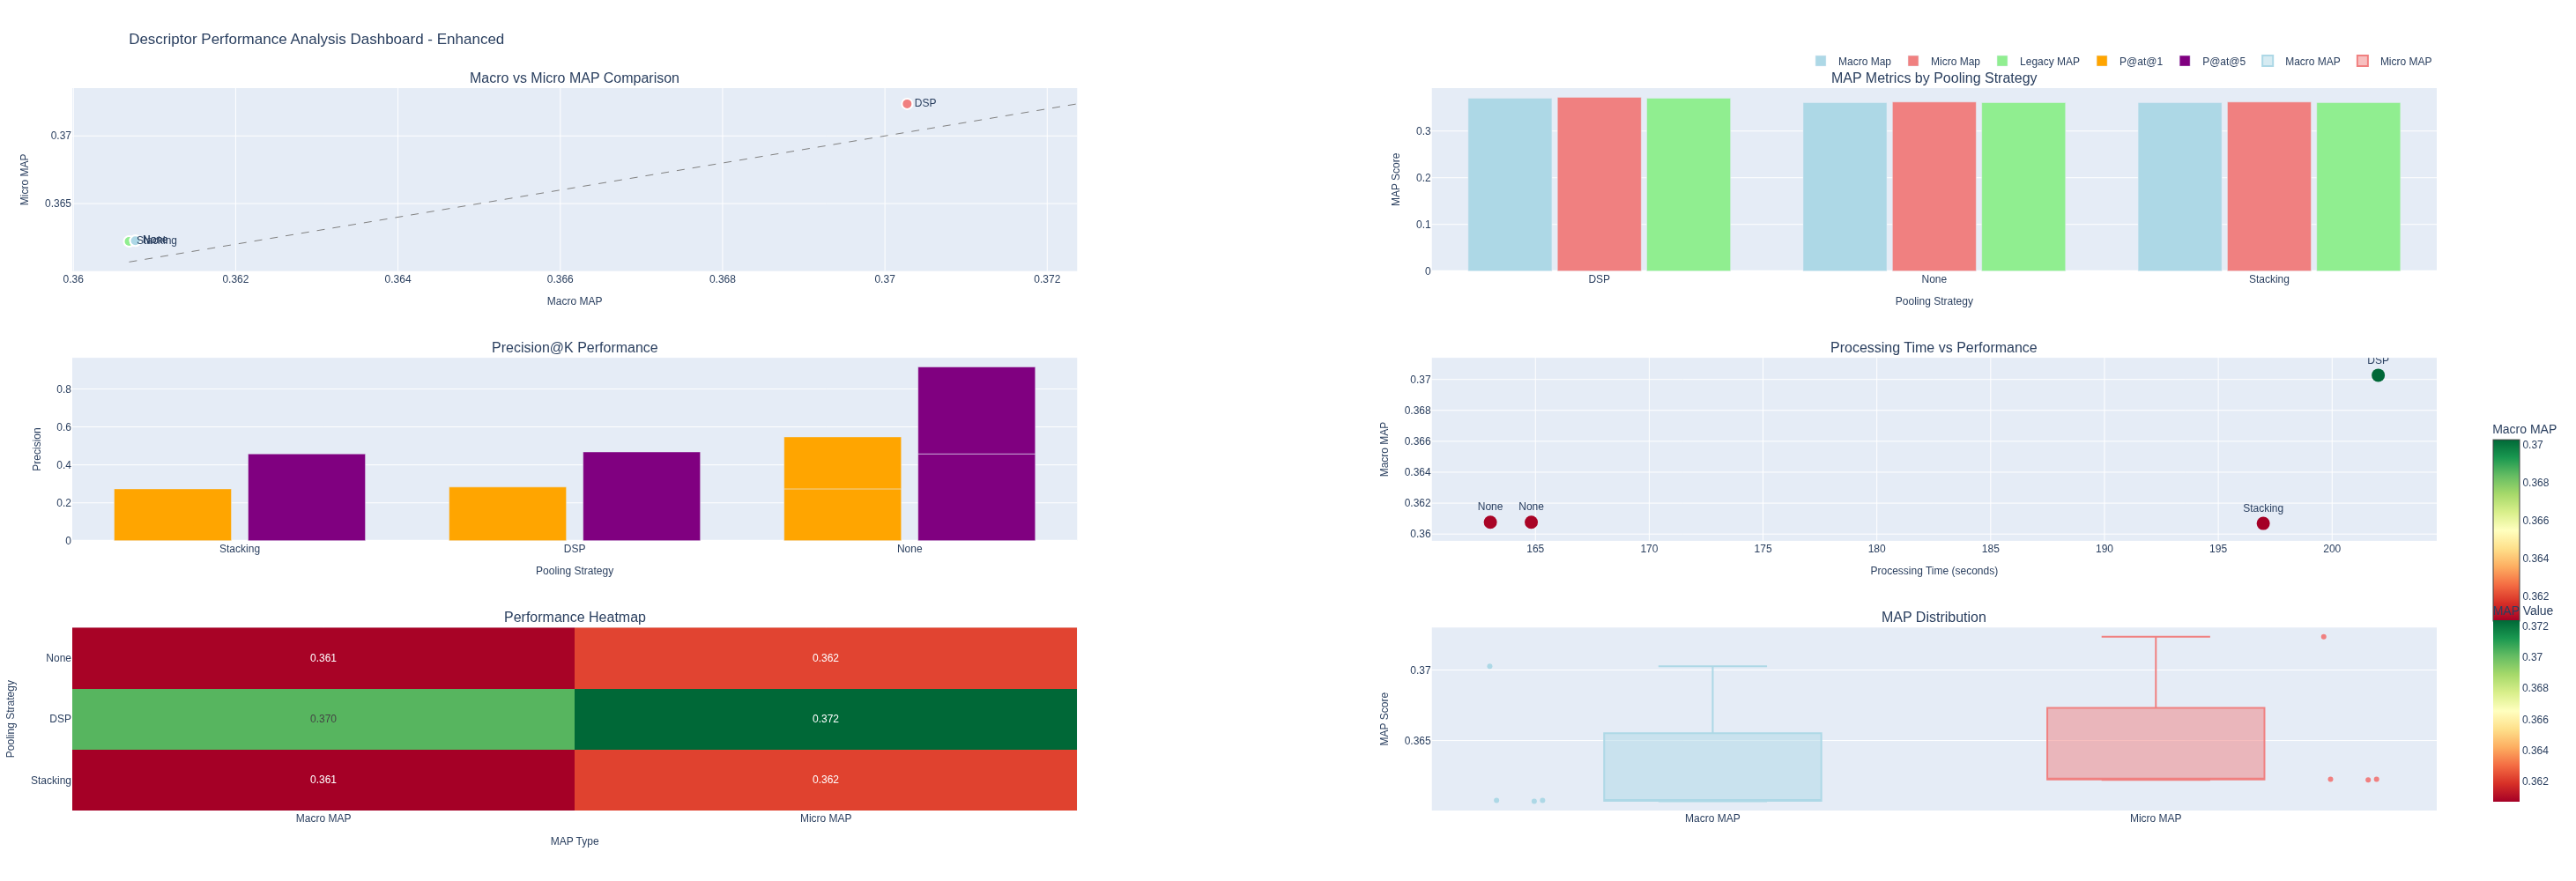

In [26]:
# Create comprehensive performance dashboard with proper layout
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Macro vs Micro MAP Comparison',
        'MAP Metrics by Pooling Strategy', 
        'Precision@K Performance',
        'Processing Time vs Performance',
        'Performance Heatmap',
        'MAP Distribution'
    ),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.15
)

# Define colors for consistent plotting
pooling_colors = {'None': 'lightblue', 'DSP': 'lightcoral', 'Stacking': 'lightgreen'}

# Plot 1: Macro vs Micro MAP comparison
fig.add_trace(
    go.Scatter(
        x=df_processed['macro_map'],
        y=df_processed['micro_map'],
        mode='markers+text',
        text=df_processed['pooling_clean'],
        textposition="middle right",
        marker=dict(
            size=12,
            color=[pooling_colors.get(p, 'gray') for p in df_processed['pooling_clean']],
            line=dict(width=2, color='white')
        ),
        name="Macro vs Micro MAP",
        showlegend=False
    ),
    row=1, col=1
)

# Add diagonal reference line for macro vs micro
min_map = min(df_processed['macro_map'].min(), df_processed['micro_map'].min())
max_map = max(df_processed['macro_map'].max(), df_processed['micro_map'].max())
fig.add_trace(
    go.Scatter(
        x=[min_map, max_map],
        y=[min_map, max_map],
        mode='lines',
        line=dict(dash='dash', color='gray', width=1),
        showlegend=False
    ),
    row=1, col=1
)

# Plot 2: MAP metrics by pooling strategy (grouped bar chart)
pooling_stats = df_processed.groupby('pooling_clean').agg({
    'macro_map': 'mean',
    'micro_map': 'mean',
    'mean_average_precision': 'mean'
}).reset_index()

colors = ['lightblue', 'lightcoral', 'lightgreen']
for i, metric in enumerate(['macro_map', 'micro_map', 'mean_average_precision']):
    fig.add_trace(
        go.Bar(
            name=metric.replace('_', ' ').title().replace('Mean Average Precision', 'Legacy MAP'),
            x=pooling_stats['pooling_clean'],
            y=pooling_stats[metric],
            marker_color=colors[i],
            offsetgroup=i,
            width=0.25
        ),
        row=1, col=2
    )

# Plot 3: Precision@K performance
precision_cols = ['precision_at_1', 'precision_at_5']
for i, col in enumerate(precision_cols):
    fig.add_trace(
        go.Bar(
            name=col.replace('_', '@').replace('precision', 'P'),
            x=df_processed['pooling_clean'],
            y=df_processed[col],
            marker_color=['orange', 'purple'][i],
            offsetgroup=i,
            width=0.35
        ),
        row=2, col=1
    )

# Plot 4: Processing time vs performance
fig.add_trace(
    go.Scatter(
        x=df_processed['processing_time_ms'] / 1000,  # Convert to seconds
        y=df_processed['macro_map'],
        mode='markers+text',
        text=df_processed['pooling_clean'],
        textposition="top center",
        marker=dict(
            size=15,
            color=df_processed['macro_map'],
            colorscale='RdYlGn',
            showscale=True,
            colorbar=dict(title="Macro MAP", len=0.3, y=0.4)
        ),
        name="Time vs Performance",
        showlegend=False
    ),
    row=2, col=2
)

# Plot 5: Performance heatmap (simplified)
# Create a simple matrix for the heatmap
heatmap_matrix = []
heatmap_labels = []
for pooling in df_processed['pooling_clean'].unique():
    subset = df_processed[df_processed['pooling_clean'] == pooling]
    if len(subset) > 0:
        heatmap_matrix.append([subset['macro_map'].mean(), subset['micro_map'].mean()])
        heatmap_labels.append(pooling)

if heatmap_matrix:
    fig.add_trace(
        go.Heatmap(
            z=heatmap_matrix,
            x=['Macro MAP', 'Micro MAP'],
            y=heatmap_labels,
            colorscale='RdYlGn',
            showscale=True,
            colorbar=dict(title="MAP Value", len=0.3, y=0.15),
            text=[[f"{val:.3f}" for val in row] for row in heatmap_matrix],
            texttemplate="%{text}",
            textfont={"size":12}
        ),
        row=3, col=1
    )

# Plot 6: MAP distribution
fig.add_trace(
    go.Box(
        y=df_processed['macro_map'],
        name="Macro MAP",
        boxpoints="all",
        jitter=0.3,
        pointpos=-1.8,
        marker=dict(color='lightblue')
    ),
    row=3, col=2
)

fig.add_trace(
    go.Box(
        y=df_processed['micro_map'],
        name="Micro MAP",
        boxpoints="all", 
        jitter=0.3,
        pointpos=1.8,
        marker=dict(color='lightcoral')
    ),
    row=3, col=2
)

# Update layout with better sizing
fig.update_layout(
    height=1000,  # Increased height for better readability
    width=1200,   # Set width for proper proportions
    title_text="Descriptor Performance Analysis Dashboard - Enhanced",
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right", 
        x=1
    )
)

# Update axis labels with proper sizing
fig.update_xaxes(title_text="Macro MAP", row=1, col=1, title_font_size=12)
fig.update_yaxes(title_text="Micro MAP", row=1, col=1, title_font_size=12)

fig.update_xaxes(title_text="Pooling Strategy", row=1, col=2, title_font_size=12)
fig.update_yaxes(title_text="MAP Score", row=1, col=2, title_font_size=12)

fig.update_xaxes(title_text="Pooling Strategy", row=2, col=1, title_font_size=12) 
fig.update_yaxes(title_text="Precision", row=2, col=1, title_font_size=12)

fig.update_xaxes(title_text="Processing Time (seconds)", row=2, col=2, title_font_size=12)
fig.update_yaxes(title_text="Macro MAP", row=2, col=2, title_font_size=12)

fig.update_xaxes(title_text="MAP Type", row=3, col=1, title_font_size=12)
fig.update_yaxes(title_text="Pooling Strategy", row=3, col=1, title_font_size=12)

fig.update_yaxes(title_text="MAP Score", row=3, col=2, title_font_size=12)

fig.show()

## Dashboard Explanation

### 🔍 **What Each Graph Shows:**

#### **Top Left: Macro vs Micro MAP Comparison**
- **Purpose**: Compare the two main evaluation metrics for each pooling strategy
- **X-axis**: Macro MAP (balanced average across scenes)
- **Y-axis**: Micro MAP (weighted by total queries)
- **Diagonal line**: Perfect correlation reference (Macro = Micro)
- **Key Insight**: Points above the line mean Micro MAP > Macro MAP
- **What we see**: All methods have Micro MAP slightly higher than Macro MAP (~0.2% difference)

#### **Top Right: MAP Metrics by Pooling Strategy**
- **Purpose**: Compare all three MAP metrics side-by-side
- **Bars**: Macro MAP (blue), Micro MAP (red), Legacy MAP (green)
- **Key Insight**: DSP pooling consistently outperforms baseline across all metrics
- **Performance ranking**: DSP > None ≈ Stacking

#### **Middle Left: Precision@K Performance** 
- **Purpose**: Show retrieval precision at different cutoff points
- **Orange bars**: Precision@1 (exact match rate)
- **Purple bars**: Precision@5 (top-5 match rate)
- **Key Insight**: P@5 is ~70% higher than P@1, indicating many correct matches rank in positions 2-5
- **Best performer**: DSP shows highest precision at both cutoffs

#### **Middle Right: Processing Time vs Performance**
- **Purpose**: Analyze efficiency trade-offs
- **X-axis**: Processing time in seconds
- **Y-axis**: Macro MAP performance
- **Color scale**: Green = higher performance
- **Key Insight**: "None" pooling is fastest (~164s) but DSP's extra ~40s gives 2.6% better MAP
- **Efficiency winner**: None (fastest), Performance winner: DSP

#### **Bottom Left: Performance Heatmap**
- **Purpose**: Visual comparison of Macro vs Micro MAP across pooling strategies
- **Green cells**: Higher performance values
- **Red cells**: Lower performance values
- **Numbers**: Actual MAP values for precise comparison
- **Key Insight**: DSP row is consistently greener (better) than others

#### **Bottom Right: MAP Distribution**
- **Purpose**: Show performance variability and outliers
- **Blue box**: Macro MAP distribution
- **Red box**: Micro MAP distribution  
- **Dots**: Individual experiment results
- **Key Insight**: Low variability suggests consistent results; Micro MAP has slightly higher values

### **Overall Takeaways:**
1. **DSP pooling** provides the best performance across all metrics
2. **Processing time trade-off**: DSP takes ~25% more time for ~2.6% better MAP
3. **Micro MAP > Macro MAP**: Suggests some scenes benefit more than others
4. **Precision gap**: Large difference between P@1 and P@5 indicates ranking could be improved

In [27]:
# Statistical summary by key factors
print("=== ENHANCED PERFORMANCE SUMMARY ===")
print("\n1. MAP Metrics Comparison:")
map_comparison = df_processed[['macro_map', 'micro_map', 'mean_average_precision']].describe()
print(map_comparison.round(4))

print("\n2. Performance by Pooling Strategy (Focus on Macro/Micro MAP):")
# Custom aggregation that handles single samples better
pooling_summary = []
for pooling in df_processed['pooling_clean'].unique():
    subset = df_processed[df_processed['pooling_clean'] == pooling]
    n = len(subset)
    
    summary_row = {
        'pooling_strategy': pooling,
        'count': n,
        'macro_map_mean': subset['macro_map'].mean(),
        'macro_map_std': subset['macro_map'].std() if n > 1 else 0.0,
        'micro_map_mean': subset['micro_map'].mean(), 
        'micro_map_std': subset['micro_map'].std() if n > 1 else 0.0,
        'precision_at_1_mean': subset['precision_at_1'].mean(),
        'precision_at_1_std': subset['precision_at_1'].std() if n > 1 else 0.0,
        'precision_at_5_mean': subset['precision_at_5'].mean(),
        'precision_at_5_std': subset['precision_at_5'].std() if n > 1 else 0.0,
    }
    pooling_summary.append(summary_row)

pooling_df = pd.DataFrame(pooling_summary)
print(pooling_df.round(4))

print("\n3. Key Performance Insights:")
best_macro = df_processed.loc[df_processed['macro_map'].idxmax()]
best_micro = df_processed.loc[df_processed['micro_map'].idxmax()]
print(f"Best Macro MAP: {best_macro['macro_map']:.4f} ({best_macro['pooling_clean']} pooling)")
print(f"Best Micro MAP: {best_micro['micro_map']:.4f} ({best_micro['pooling_clean']} pooling)")

# Performance improvements vs baseline
baseline_macro = df_processed[df_processed['pooling_clean'] == 'None']['macro_map'].mean()
baseline_micro = df_processed[df_processed['pooling_clean'] == 'None']['micro_map'].mean()
best_macro_improvement = ((best_macro['macro_map'] - baseline_macro) / baseline_macro) * 100
best_micro_improvement = ((best_micro['micro_map'] - baseline_micro) / baseline_micro) * 100

print(f"DSP vs None improvement: {best_macro_improvement:.2f}% (macro), {best_micro_improvement:.2f}% (micro)")

print(f"\n4. Macro vs Micro MAP Analysis:")
macro_micro_diff = df_processed['macro_map'] - df_processed['micro_map']
print(f"Average difference (Macro - Micro): {macro_micro_diff.mean():.4f}")
print(f"Max difference: {macro_micro_diff.max():.4f}")
print(f"Min difference: {macro_micro_diff.min():.4f}")
print("Note: Negative values indicate Micro MAP > Macro MAP")

print(f"\n5. Processing Efficiency Analysis:")
df_processed['map_per_second'] = df_processed['macro_map'] / (df_processed['processing_time_ms'] / 1000)
print("Efficiency Metrics (Macro MAP per Second):")
for pooling in df_processed['pooling_clean'].unique():
    subset = df_processed[df_processed['pooling_clean'] == pooling]
    mean_eff = subset['map_per_second'].mean()
    std_eff = subset['map_per_second'].std() if len(subset) > 1 else 0.0
    processing_time = subset['processing_time_ms'].mean() / 1000  # Convert to seconds
    print(f"  {pooling:>10}: {mean_eff:.6f} ± {std_eff:.6f} MAP/sec ({processing_time:.1f}s avg)")

print(f"\n6. Dataset Summary:")
print(f"Total experiments analyzed: {len(df_processed)}")
print(f"Pooling strategies tested: {', '.join(df_processed['pooling_clean'].unique())}")
print(f"MAP range: {df_processed['macro_map'].min():.4f} - {df_processed['macro_map'].max():.4f}")
print(f"Processing time range: {df_processed['processing_time_ms'].min()/1000:.1f}s - {df_processed['processing_time_ms'].max()/1000:.1f}s")

=== ENHANCED PERFORMANCE SUMMARY ===

1. MAP Metrics Comparison:
       macro_map  micro_map  mean_average_precision
count     4.0000     4.0000                  4.0000
mean      0.3631     0.3648                  0.3631
std       0.0048     0.0051                  0.0048
min       0.3607     0.3622                  0.3607
25%       0.3607     0.3622                  0.3607
50%       0.3608     0.3623                  0.3608
75%       0.3631     0.3648                  0.3631
max       0.3703     0.3724                  0.3703

2. Performance by Pooling Strategy (Focus on Macro/Micro MAP):
  pooling_strategy  count  macro_map_mean  macro_map_std  micro_map_mean  \
0         Stacking      1          0.3607            0.0          0.3622   
1              DSP      1          0.3703            0.0          0.3724   
2             None      2          0.3608            0.0          0.3623   

   micro_map_std  precision_at_1_mean  precision_at_1_std  \
0            0.0               0.2736

In [12]:
# Export results for further analysis
output_dir = Path("../outputs")
output_dir.mkdir(exist_ok=True)

# Save processed data
df_processed.to_csv(output_dir / "descriptor_performance_analysis.csv", index=False)

# Save summary statistics
with open(output_dir / "performance_summary.txt", 'w') as f:
    f.write("DESCRIPTOR PERFORMANCE ANALYSIS SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("BASE DESCRIPTOR PERFORMANCE:\n")
    f.write(base_desc_stats.to_string())
    f.write("\n\nPOOLING STRATEGY PERFORMANCE:\n")
    f.write(pooling_stats.to_string())
    f.write("\n\nCOLOR USAGE PERFORMANCE:\n")
    f.write(color_stats.to_string())

print(f"Analysis results exported to {output_dir}")
print(f"Total experiments analyzed: {len(df_processed)}")

Analysis results exported to ../outputs
Total experiments analyzed: 4
